## Data Understanding

In this phase, data is collected and analyzed to gain insights and inform the modeling process. This phase includes:

Gather Data: Identify and collect data from various sources related to the problem. This may involve data from internal databases, external providers, or a combination of both.

Validate Data: Ensure the quality of the data by addressing missing values, correcting errors, and handling outliers. This step ensures the reliability of the subsequent analysis.

Explore the Data: Conduct exploratory data analysis (EDA) using statistical methods and visualization techniques to see the patterns, relationships, and initial insights.

In [1]:
import pandas as pd

file_path = "dataset.xlsx"

# Load data
ib_data = pd.read_excel(file_path, sheet_name="DATA IB")
ik_data = pd.read_excel(file_path, sheet_name="DATA IK")

# Ambil kolom yang relevan dan ubah nama
ib_data = ib_data[["desc"]].rename(columns={"desc": "keperluan"})
ik_data = ik_data[["tujuan"]].rename(columns={"tujuan": "keperluan"})

# Tambahkan kolom penanda
ib_data["izin"] = "IB"
ik_data["izin"] = "IK"

# Gabungkan data
combined_data = pd.concat([ib_data, ik_data], ignore_index=True)

# Pembersihan teks
combined_data["keperluan"] = combined_data["keperluan"].str.strip().str.lower()

# Validasi data
print("Jumlah nilai kosong per kolom:")
print(combined_data.isnull().sum())

# Hapus nilai kosong
combined_data.dropna(subset=["keperluan"], inplace=True)

# Hapus duplikat
combined_data.drop_duplicates(subset=["keperluan"], inplace=True)

# Periksa distribusi kategori
print("\nDistribusi kategori izin:")
print(combined_data["izin"].value_counts())

# Simpan data gabungan
combined_data.to_csv("combined_ib_ik_keperluan.csv", index=False)

# Tampilkan data acak
print("\nData sampel:")
print(combined_data.sample(5))


Jumlah nilai kosong per kolom:
keperluan    0
izin         0
dtype: int64

Distribusi kategori izin:
izin
IB    2271
IK    1168
Name: count, dtype: int64

Data sampel:
                                               keperluan izin
80157  mempercepat izin bermalam dikarenakan adanya w...   IK
59851  menukar celana kuliah yang sudah rusak kancing...   IB
37906         libur semester dan program beasiswa iisma.   IB
1515                                  berjumpa orang tua   IB
77217          pulang kerumah dan pelayanan sabtu minggu   IB


 ## Exploratory Data Analysis (EDA)

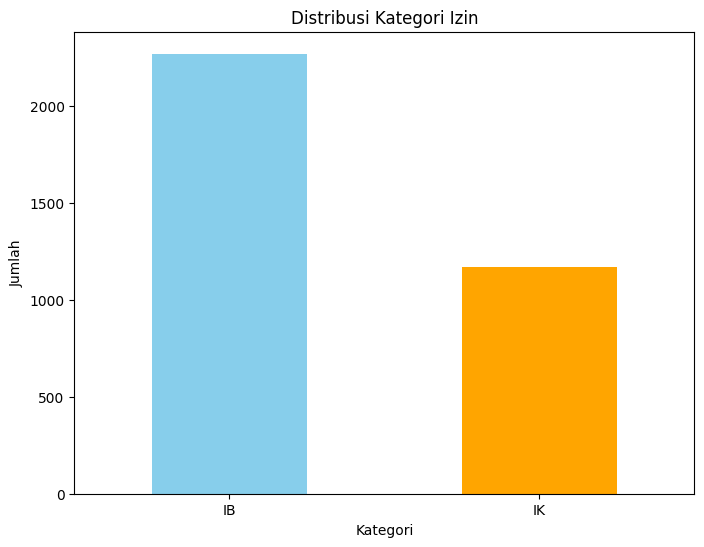

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi kategori izin
category_counts = combined_data["izin"].value_counts()
category_counts.plot(kind="bar", color=["skyblue", "orange"], figsize=(8, 6))
plt.title("Distribusi Kategori Izin")
plt.xlabel("Kategori")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)
plt.show()


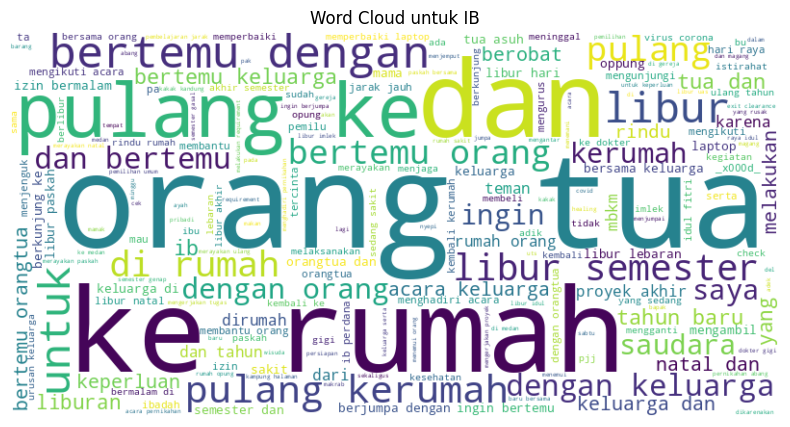

10 Kata Paling Umum dalam Keperluan IB:
dan: 533
libur: 370
rumah: 341
ke: 339
keluarga: 331
bertemu: 327
orang: 318
pulang: 314
tua: 283
dengan: 196


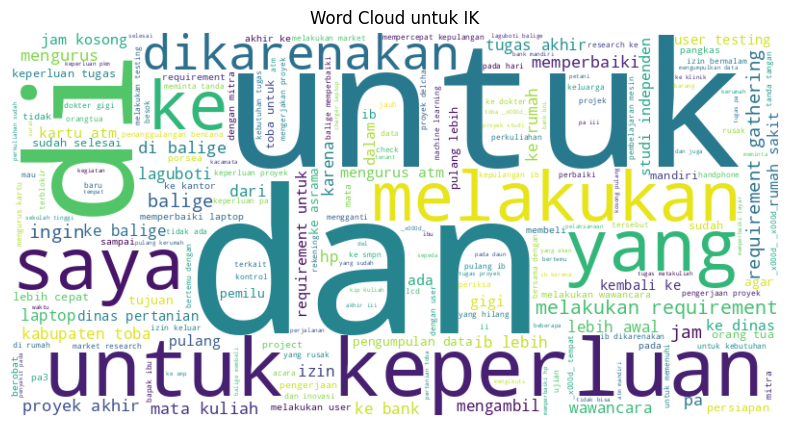

10 Kata Paling Umum dalam Keperluan IK:
untuk: 367
ke: 339
dan: 274
melakukan: 231
di: 179
keperluan: 171
requirement: 149
yang: 146
balige: 140
proyek: 113


In [5]:
from wordcloud import WordCloud
from collections import Counter

# Gabungkan teks berdasarkan izin
text_ib = " ".join(combined_data[combined_data["izin"] == "IB"]["keperluan"])
text_ik = " ".join(combined_data[combined_data["izin"] == "IK"]["keperluan"])

word_counts_ib = Counter(text_ib.split())
word_counts_ik = Counter(text_ik.split())


# Word Cloud untuk IB
wordcloud_ib = WordCloud(width=800, height=400, background_color="white").generate(text_ib)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ib, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud untuk IB")
plt.show()

# Tampilkan kata paling umum
common_words_ib = word_counts_ib.most_common(10)
print("10 Kata Paling Umum dalam Keperluan IB:")
for word, count in common_words_ib:
    print(f"{word}: {count}")

# Word Cloud untuk IK
wordcloud_ik = WordCloud(width=800, height=400, background_color="white").generate(text_ik)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ik, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud untuk IK")
plt.show()

# Tampilkan kata paling umum
common_words_ik = word_counts_ik.most_common(10)
print("10 Kata Paling Umum dalam Keperluan IK:")
for word, count in common_words_ik:
    print(f"{word}: {count}")


In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode kolom 'izin'
label_encoder = LabelEncoder()
combined_data["izin_encoded"] = label_encoder.fit_transform(combined_data["izin"])

# Tampilkan hasil encoding
print("Mapping kategori izin ke numerik:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Mapping kategori izin ke numerik:
{'IB': 0, 'IK': 1}


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vektorisasi
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data["keperluan"])

# Tampilkan fitur TF-IDF
print("Beberapa fitur TF-IDF:")
print(tfidf_vectorizer.get_feature_names_out()[:10])


Beberapa fitur TF-IDF:
['00' '10' '13' '14' '15' '16' '17' '18' '19' '2022']


In [8]:
import numpy as np

# Gabungkan data ke dalam array numpy
prepared_data = np.hstack((tfidf_matrix.toarray(), combined_data[["izin_encoded"]].values))

# Periksa bentuk data
print("Shape data setelah digabungkan:", prepared_data.shape)


Shape data setelah digabungkan: (3439, 501)


In [9]:
from sklearn.model_selection import train_test_split

# Bagi data
X = prepared_data[:, :-1]  # Fitur
y = prepared_data[:, -1]   # Label (izin_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan ukuran data
print("Ukuran data training:", X_train.shape)
print("Ukuran data testing:", X_test.shape)


Ukuran data training: (2751, 500)
Ukuran data testing: (688, 500)


In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Menentukan jumlah cluster (eksperimen untuk menemukan optimal k)
k_values = range(2, 10)
kmeans_results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)  # Hanya pada data training
    score = silhouette_score(X_train, kmeans.labels_)
    kmeans_results.append((k, score))

# Menemukan k terbaik berdasarkan silhouette score
best_k = max(kmeans_results, key=lambda x: x[1])[0]
print(f"Optimal k untuk K-Means: {best_k}")

# Model final K-Means
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_kmeans.fit(X_train)
kmeans_labels = final_kmeans.predict(X_test)


Optimal k untuk K-Means: 9


In [11]:
from sklearn.cluster import AgglomerativeClustering

# Eksperimen dengan linkage
linkages = ['ward', 'complete', 'average']
agglo_results = []

for linkage in linkages:
    agglo = AgglomerativeClustering(n_clusters=best_k, linkage=linkage)
    agglo.fit(X_train)
    labels = agglo.fit_predict(X_train)
    score = silhouette_score(X_train, labels)
    agglo_results.append((linkage, score))

# Menemukan linkage terbaik
best_linkage = max(agglo_results, key=lambda x: x[1])[0]
print(f"Linkage terbaik untuk Agglomerative Clustering: {best_linkage}")

# Model final Agglomerative Clustering
final_agglo = AgglomerativeClustering(n_clusters=best_k, linkage=best_linkage)
final_agglo.fit(X_train)
agglo_labels = final_agglo.fit_predict(X_test)


Linkage terbaik untuk Agglomerative Clustering: average


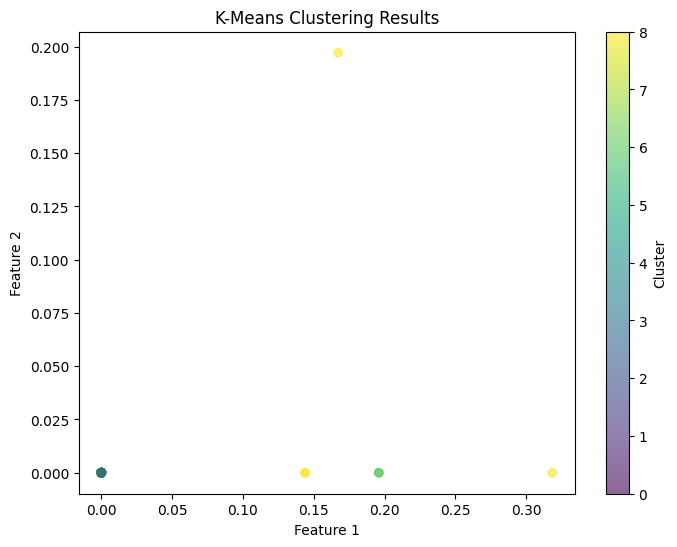

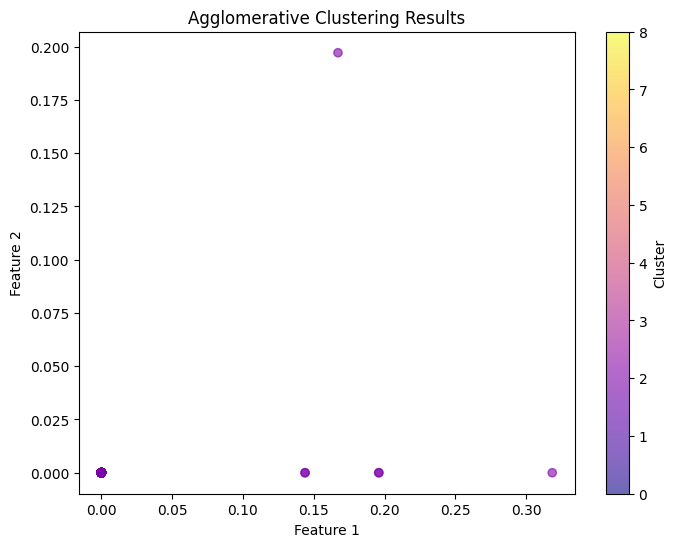

Silhouette score K-Means: 0.05605977158879632
Silhouette score Agglomerative: 0.02473838316927059


In [12]:
import matplotlib.pyplot as plt

# Visualisasi hasil K-Means
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title("K-Means Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster')
plt.show()

# Visualisasi hasil Agglomerative Clustering
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=agglo_labels, cmap='plasma', alpha=0.6)
plt.title("Agglomerative Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster')
plt.show()

# Silhouette score comparison
print(f"Silhouette score K-Means: {silhouette_score(X_test, kmeans_labels)}")
print(f"Silhouette score Agglomerative: {silhouette_score(X_test, agglo_labels)}")
